In [1]:
# Standard Library Imports
import math
import os
import itertools

# Third-Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.layers import Layer, Dense, Conv2D, Reshape, Permute, Dropout, Activation, Add, Multiply, MultiHeadAttention, GlobalMaxPooling2D, GlobalAveragePooling2D, LayerNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau

# remove warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Dataset laocation
benign = '/kaggle/input/breakhiss/HPI/40X/Benign'
malignant = '/kaggle/input/breakhiss/HPI/40X/Malignant'

In [3]:
dirlist=[benign, malignant]
classes=['B', 'M']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  1995    labels:  1995


In [4]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(1995,2), columns = ['filepaths', 'labels']) # Update with filepath value
df.head()

,filepaths,labels
0,/kaggle/input/breakhiss/HPI/40X/Benign/SOB_B_F...,B
1,/kaggle/input/breakhiss/HPI/40X/Benign/SOB_B_A...,B
2,/kaggle/input/breakhiss/HPI/40X/Benign/SOB_B_A...,B
3,/kaggle/input/breakhiss/HPI/40X/Benign/SOB_B_A...,B
4,/kaggle/input/breakhiss/HPI/40X/Benign/SOB_B_F...,B


In [5]:
print(df['labels'].value_counts())

labels
M    1370
B     625
Name: count, dtype: int64


In [6]:
# Train - Test split
train, test = train_test_split(df, train_size=0.70, random_state=0)
print(f"train set shape: {train.shape}")
print(f"test set shape: {test.shape}")

train set shape: (1396, 2)
test set shape: (599, 2)


In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [8]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 16,
                                              class_mode = 'categorical', shuffle = True)

test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'categorical',
                                            batch_size = 16, shuffle = False)

Found 1396 validated image filenames belonging to 2 classes.
Found 599 validated image filenames belonging to 2 classes.


In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plotmodel(history,name):

    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(1)
    plt.plot(epochs,smooth_curve(acc))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_acc'], loc='upper left')

    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss'], loc='upper right')

def label_smooth(y_true, y_pred):
    y_true=((1-0.1)*y_true+0.05)
    return K.categorical_crossentropy(y_true, y_pred)

In [10]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="green" if cm[i, j] > thresh else "red", fontdict={'fontsize':'x-large'})

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
@register_keras_serializable()
class EnhancedAttentionMechanism(Layer):
    def __init__(self, filters, reduction=8, num_heads=3, dropout_rate=0.3, **kwargs):
        """
        Enhanced Attention Mechanism (EAM) with Multi-Head Self-Attention (MHSA).
        
        Parameters:
        - filters: Number of filters in the input tensor.
        - reduction: Reduction ratio for channel attention.
        - num_heads: Number of attention heads for MHSA.
        - dropout_rate: Dropout rate for regularization.
        """
        super(EnhancedAttentionMechanism, self).__init__(**kwargs)
        self.filters = filters
        self.reduction = reduction
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        # Channel Attention components
        self.global_max_pool = GlobalMaxPooling2D()
        self.dense1 = Dense(filters // reduction, activation='relu', kernel_regularizer=l2(1e-3))
        self.dense2 = Dense(filters, activation='sigmoid', kernel_regularizer=l2(1e-3))

        # Spatial Attention components
        self.conv_spatial = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

        # Multi-Head Self-Attention (MHSA)
        self.mhsa = MultiHeadAttention(num_heads=num_heads, key_dim=filters)

        # Dropout for regularization
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs):
        # Channel Attention (Global Context)
        avg_pool = self.global_max_pool(inputs)
        channel_attention = self.dense1(avg_pool)
        channel_attention = self.dense2(channel_attention)
        channel_attention = Reshape((1, 1, self.filters))(channel_attention)
        channel_refined = Multiply()([inputs, channel_attention])

        # Spatial Attention (Local Features)
        spatial_attention = self.conv_spatial(channel_refined)
        spatial_refined = Multiply()([inputs, spatial_attention])

        # Multi-Head Self-Attention (Long-Range Dependencies)
        # Flatten spatial dimensions to allow MHSA processing
        batch_size, height, width, channels = inputs.shape
        flattened_inputs = Reshape((height * width, channels))(inputs)
        mhsa_output = self.mhsa(flattened_inputs, flattened_inputs)
        mhsa_output = Reshape((height, width, channels))(mhsa_output)

        # Combine Channel, Spatial, and MHSA Outputs
        combined = Add()([channel_refined, spatial_refined, mhsa_output])
        return self.dropout(combined)

    def get_config(self):
        config = super(EnhancedAttentionMechanism, self).get_config()
        config.update({
            "filters": self.filters,
            "reduction": self.reduction,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate,
        })
        return config


In [12]:
def train_model(model, train_gen, test_gen, mag, image_size, save_name, lr1, lr2, Epochs1, Epochs2):
    lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    save_model = ModelCheckpoint(
        filepath=f'RDTNet/{mag}/{save_name}/{save_name}'+'{epoch:02d}.keras',
        monitor='accuracy',
        save_best_only=True,
        mode='max'
    )

    # Freeze base model layers
    for layer in model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=lr1, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        train_gen,
        epochs=Epochs1,
        callbacks=[lr_decay, save_model]
    )

    # Unfreeze base model layers
    for layer in model.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=lr2, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_gen,
        epochs=Epochs2,
        callbacks=[lr_decay, save_model]
    )

    # Evaluate the model
    results = model.evaluate(test_gen)
    print('Test loss and accuracy: ', results)

    # Predictions and confusion matrix
    predictions = model.predict(test_gen)
    rounded_pred = np.argmax(predictions, axis=-1)
    cm = confusion_matrix(y_true=test_gen.classes, y_pred=rounded_pred)
    cm_plot_labels = ['B', 'M']
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
    print(classification_report(y_true=test_gen.classes, y_pred=rounded_pred, target_names=cm_plot_labels))
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_gen.classes, rounded_pred))
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    return history


In [13]:
loss_fun= 'categorical_crossentropy'
gpu_num=1
k=5
lr1=0.005
lr2=0.0001
image_size=224
fltr=1920
classes=2
mag='40'

In [14]:
# Initialize the DenseNet model without the top fully connected layers, using pre-trained ImageNet weights
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape = (image_size, image_size, 3))

# Save the input and output tensors of the base model
base_in = base_model.input
base_out = base_model.output

# Apply layer normalization to the output of the base model
x = LayerNormalization(epsilon=1e-6)(base_out)

# Initialize a custom self-attention layer with specified parameters
eam_layer = EnhancedAttentionMechanism(filters=x.shape[-1])

# Apply the self-attention layer to the normalized output
eam_op = eam_layer(x)

# Add the backbone output and the self-attention output (residual connection)
y = Add()([base_out, eam_op])

# Apply another layer normalization to the self-attention output
x = LayerNormalization(epsilon=1e-6)(y)

# Apply a 1x1 convolution with filters, l2 regularizer and ReLU activation
x = Conv2D(filters=x.shape[-1], kernel_size=1, padding='same', activation='relu')(x)

# Add the convolution output and the previous addition output (residual connection)
x = Add()([x, y])

# Apply global average pooling to reduce each feature map to a single value
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with softmax activation for classification
out = Dense(2, activation='softmax')(x)

# Create the final model from the input of the base model to the output layer
model = Model(base_in, out, name="DREAMNet")
    
# Print the summary of the model
model.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "DREAMNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 67,295,667 (256.71 MB)

 Trainable params: 67,066,611 (255.84 MB)

 Non-trainable params: 229,056 (894.75 KB)

Epoch 1/2


I0000 00:00:1734097409.890011      95 service.cc:145] XLA service 0x7f84640014a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734097409.890076      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/88 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.6875 - loss: 0.8426  

I0000 00:00:1734097428.195259      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 101s 774ms/step - accuracy: 0.6939 - loss: 1.0582 - learning_rate: 0.0050
Epoch 2/2
88/88 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.7023 - loss: 1.1424 - learning_rate: 0.0050
Epoch 1/70


I0000 00:00:1734097811.051802      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_21', 24 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_26', 20 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_27', 24 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_28', 8 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_50', 4 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_51', 8 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_716', 20 byte

47/88 ━━━━━━━━━━━━━━━━━━━━ 15s 366ms/step - accuracy: 0.7720 - loss: 1.6683

2024-12-13 13:53:56.276010: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_156423__.91768] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
I0000 00:00:1734098041.221961      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_14', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_15', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_17', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function

88/88 ━━━━━━━━━━━━━━━━━━━━ 527s 3s/step - accuracy: 0.8121 - loss: 1.4745 - learning_rate: 1.0000e-04
Epoch 2/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 413ms/step - accuracy: 0.9226 - loss: 0.9372 - learning_rate: 1.0000e-04
Epoch 3/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.9541 - loss: 0.7161 - learning_rate: 1.0000e-04
Epoch 4/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 362ms/step - accuracy: 0.9518 - loss: 0.6490 - learning_rate: 1.0000e-04
Epoch 5/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 406ms/step - accuracy: 0.9514 - loss: 0.6150 - learning_rate: 1.0000e-04
Epoch 6/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 415ms/step - accuracy: 0.9614 - loss: 0.5105 - learning_rate: 1.0000e-04
Epoch 7/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 414ms/step - accuracy: 0.9872 - loss: 0.3975 - learning_rate: 1.0000e-04
Epoch 8/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step - accuracy: 0.9640 - loss: 0.4099 - learning_rate: 1.0000e-04
Epoch 9/70
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 415ms/step - accuracy: 0.9745 - loss: 0.3699 - lear

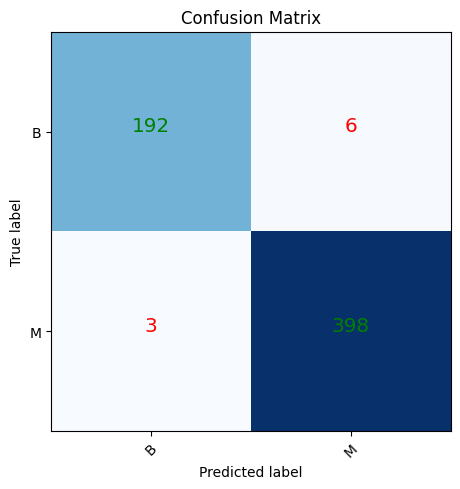

In [15]:
history_40 =train_model(model,train_gen,test_gen,mag,image_size,'DREAMNet',lr1,lr2,2,50)

In [ ]:
plotmodel(history_400,'DREAMNet')